In [11]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers, blas

def get_first_values(data):
    print (data.iloc(0))

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 8, 1)
shift = 1 #daily

symbols = [
    #'IJH', #iShares Core S&P 500 Mid-Cap
    #'IVW', #iShares S&P 500 Growth
    #'IJR', #iShares Core S&P 500 Small-Cap
    #'AAPL',
    #'GLD',
    #'SPY',
    'VTI',
    #'VTV',
    #'VOE',
    #'VBR',
    'VEA', # Foreign stocks
    'VWO', # Emerging markets
    'VIG', # Dividend stocks
    'VNQ', # Real Estate
    #'VTIP',
    #'SHV',
    #'MUB',
    'LQD', # Corporate Bonds
    'EMB', # EM Bonds
    #'VWOB',
    'SH',
 ]

data = {}
for symbol in symbols:
    data[symbol] = web.DataReader(symbol, 'yahoo', start, end)

price = pd.DataFrame({sym: dataframe['Adj Close'] for sym,dataframe in data.items()})

print (price)

                   EMB         LQD          SH        VEA        VIG  \
Date                                                                   
2010-01-04   74.321208   80.741873  103.400002  28.676275  40.992070   
2010-01-05   74.773277   81.127460  103.059998  28.692606  40.966151   
2010-01-06   74.875356   80.888398  103.080002  28.700773  40.992070   
2010-01-07   74.488913   80.988649  102.559998  28.643616  41.199404   
2010-01-08   74.576406   81.166021  102.239998  28.953893  41.199404   
2010-01-11   75.145134   81.250851  102.120003  29.133529  41.441299   
2010-01-12   75.159720   81.405083  103.059998  28.798755  41.303075   
2010-01-13   74.992016   81.065771  102.180000  29.068205  41.519050   
2010-01-14   74.598279   81.358814  101.900002  29.231511  41.596801   
2010-01-15   74.554533   81.327967  103.019997  28.757929  41.164851   
2010-01-19   74.671198   81.397375  101.760002  29.076372  41.622717   
2010-01-20   74.758691   81.343394  102.779999  28.333337  41.21

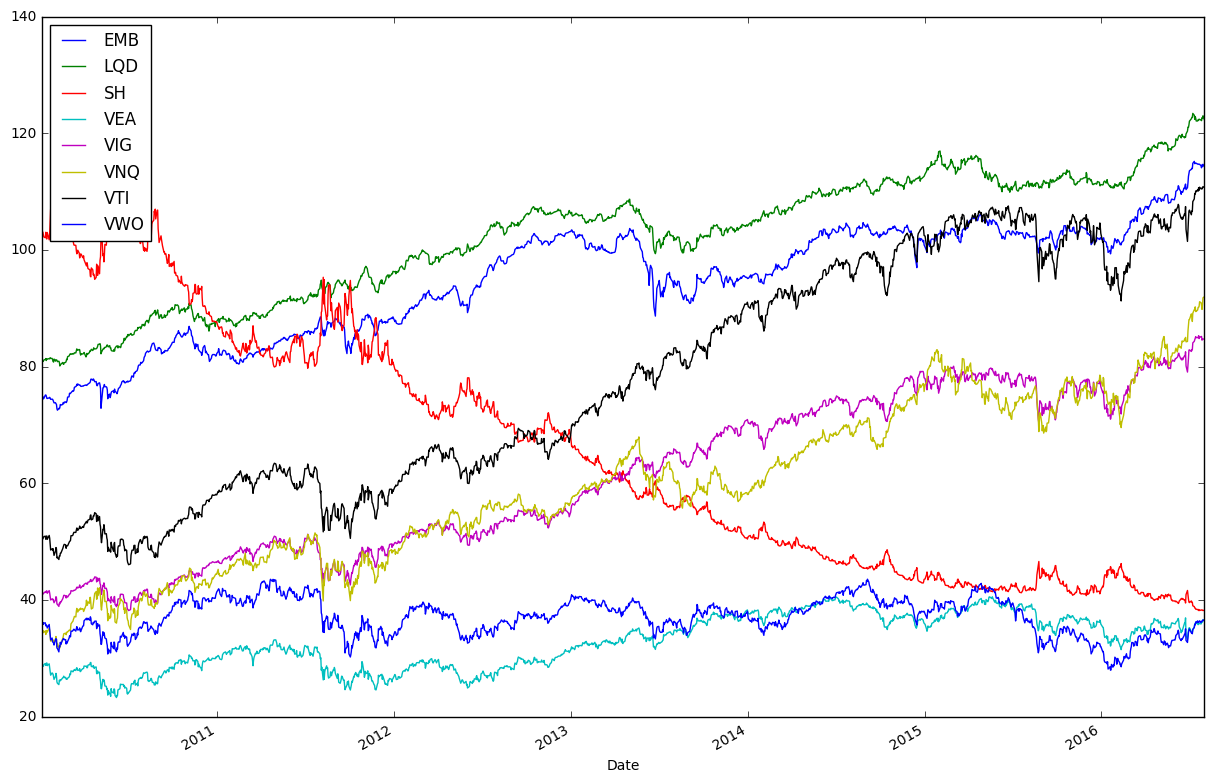

In [12]:
price.plot(figsize=(15,10))
plt.show()

In [13]:
#252 trading days a year
#avg_yearly_returns = (price/price.shift(252)-1).mean()

daily_returns = (price/price.shift(shift)) - 1
daily_returns_mean = daily_returns.mean()
daily_returns_variance = daily_returns.var()
daily_returns_covariance = daily_returns.cov()

#print ("Average Returns:\n%s\n" % (avg_yearly_returns*100))
print ("Daily Returns Mean:\n%s\n" % daily_returns_mean)
print ("Daily Returns Variance:\n%s" % daily_returns_variance)
print ("Daily Returns Covariance:\n%s" % daily_returns_covariance)

Daily Returns Mean:
EMB    0.000270
LQD    0.000257
SH    -0.000551
VEA    0.000227
VIG    0.000479
VNQ    0.000670
VTI    0.000530
VWO    0.000111
dtype: float64

Daily Returns Variance:
EMB    0.000021
LQD    0.000012
SH     0.000099
VEA    0.000163
VIG    0.000080
VNQ    0.000154
VTI    0.000104
VWO    0.000199
dtype: float64
Daily Returns Covariance:
          EMB           LQD        SH       VEA       VIG       VNQ       VTI  \
EMB  0.000021  5.392842e-06 -0.000017  0.000025  0.000015  0.000022  0.000018   
LQD  0.000005  1.217314e-05  0.000004 -0.000003 -0.000003  0.000004 -0.000004   
SH  -0.000017  3.878819e-06  0.000099 -0.000114 -0.000087 -0.000096 -0.000101   
VEA  0.000025 -3.080681e-06 -0.000114  0.000163  0.000100  0.000113  0.000117   
VIG  0.000015 -3.298218e-06 -0.000087  0.000100  0.000080  0.000085  0.000089   
VNQ  0.000022  3.830618e-06 -0.000096  0.000113  0.000085  0.000154  0.000100   
VTI  0.000018 -3.737921e-06 -0.000101  0.000117  0.000089  0.000100  0.00010

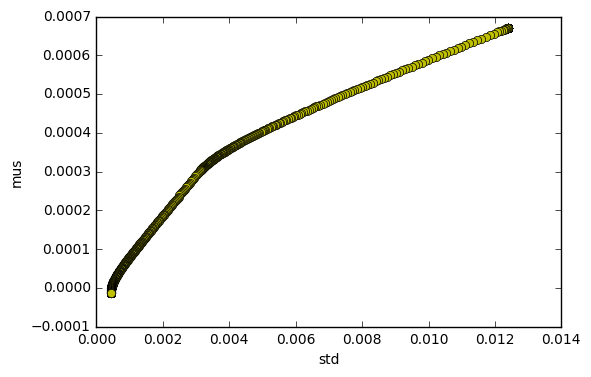

In [14]:
n = len(symbols)

N = 1000
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
S = matrix(daily_returns_covariance.values)
pbar = matrix(daily_returns_mean.values)
    
# Create constraint matrices
G = -matrix(np.eye(n))   # negative n x n identity matrix
h = matrix(0.0, (n ,1))
A = matrix(1.0, (1, n))
b = matrix(1.0)
    
# Calculate efficient frontier weights using quadratic programming
solvers.options['show_progress'] = False
portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
              for mu in mus]

## CALCULATE RISKS AND RETURNS FOR FRONTIER
returns = [blas.dot(pbar, x) for x in portfolios]
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

plt.ylabel('mus')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()

[  2.35694458e+04   1.94311130e+00   5.03697775e-04]
0.00615091063072
0.000146187530815
-841.307426917
Terminated (singular KKT matrix).


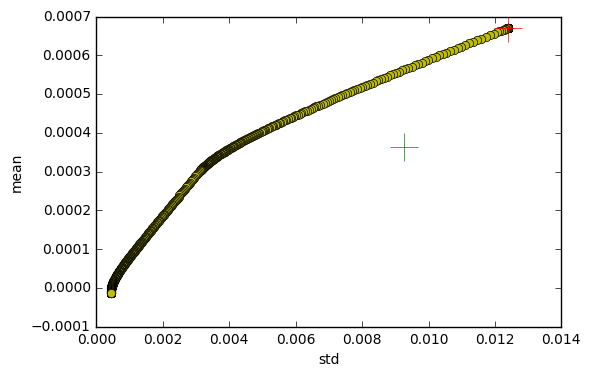

NameError: name 'wt' is not defined

In [15]:
## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
m1 = np.polyfit(returns, risks, 2)
print (m1)
v = 0.00045
print (m1[0]*(v**2)+m1[1]*v+m1[2])
x1 = np.sqrt(m1[2] / m1[0])
print (x1)

## CALCULATE THE OPTIMAL PORTFOLIO
qp = solvers.qp(matrix(x1 * S), -pbar, G, h, A, b)['x']

m2 = np.polyfit(risks, mus, 2)
riskp = 0.55
v = np.min(risks)+(np.max(risks)-np.min(risks))*riskp
r = m2[0]*(v**2)+m2[1]*v+m2[2]
print (r)

## CALCULATE THE OPTIMAL PORTFOLIO
mp = solvers.qp(matrix(r * S), -pbar, G, h, A, b)['x']

plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.plot(np.sqrt(blas.dot(qp, S*qp)), blas.dot(pbar, qp), 'r+', markersize=20)
plt.plot(np.sqrt(blas.dot(mp, S*mp)), blas.dot(pbar, mp), 'g+', markersize=20)
plt.show()

for i in range(len(symbols)):
    print ("%s\t%f" % (symbols[i], (wt[i]*100)))

In [ ]:
y = (price/price.shift(252))-1
ym = np.matrix(y.mean().values)
print (ym*np.array(wt))